# Deep Learning - Lab Sections :  Convolution Neural Networks

Starting with importing some libraries which we are going to use further.

In [13]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import (LinearRegression, LogisticRegression, Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import (train_test_split, GridSearchCV)

#importing pytorch
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset

from torchmetrics import (MeanAbsoluteError, R2Score)
from torchinfo import summary
from torchvision.io import read_image

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50, ResNet50_Weights)
from torchvision.transforms import (Resize, Normalize, CenterCrop, ToTensor)

from ISLP.torch import (SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers)
from ISLP.torch.imdb import (load_lookup, load_tensor, load_sparse, load_sequential)

from glob import glob
import json

## 10.9.3 Convolutional Neural Networks
We fit a CNN to the `CIFAR100` data, which is available in the `torchvision`
package. It is arranged in a similar fashion as the `MNIST` data.

In [14]:
(cifar_train, cifar_test) = [CIFAR100(root="data", train=train,download=True) for train in [True, False]]

Files already downloaded and verified
Files already downloaded and verified


In [15]:
transform = ToTensor()
cifar_train_X = torch.stack([transform(x) for x in
                            cifar_train.data])
cifar_test_X = torch.stack([transform(x) for x in
                            cifar_test.data])
cifar_train = TensorDataset(cifar_train_X,
                            torch.tensor(cifar_train.targets))
cifar_test = TensorDataset(cifar_test_X,
                            torch.tensor(cifar_test.targets))

The `CIFAR100` dataset consists of 50,000 training images, each represented by a three-dimensional tensor:
each three-color image is represented as a set of three channels, each of which consists of
$32\times 32$ eight-bit pixels. We standardize as we did for the
digits, but keep the array structure. This is accomplished with the `ToTensor()` transform.

Creating the data module is similar to the `MNIST`  example.

In [16]:
max_num_workers = rec_num_workers()

In [17]:
cifar_dm = SimpleDataModule(cifar_train, cifar_test, validation=0.2, num_workers=max_num_workers, batch_size=128)

We again look at the shape of typical batches in our data loaders.

In [18]:
for idx, (X_ ,Y_) in enumerate(cifar_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break

X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])
X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])


Before we start, we look at some of the training images; The example below also illustrates
that `TensorDataset` objects can be indexed with integers --- we are choosing
random images from the training data by indexing `cifar_train`. In order to display correctly,
we must reorder the dimensions by a call to `np.transpose()`.

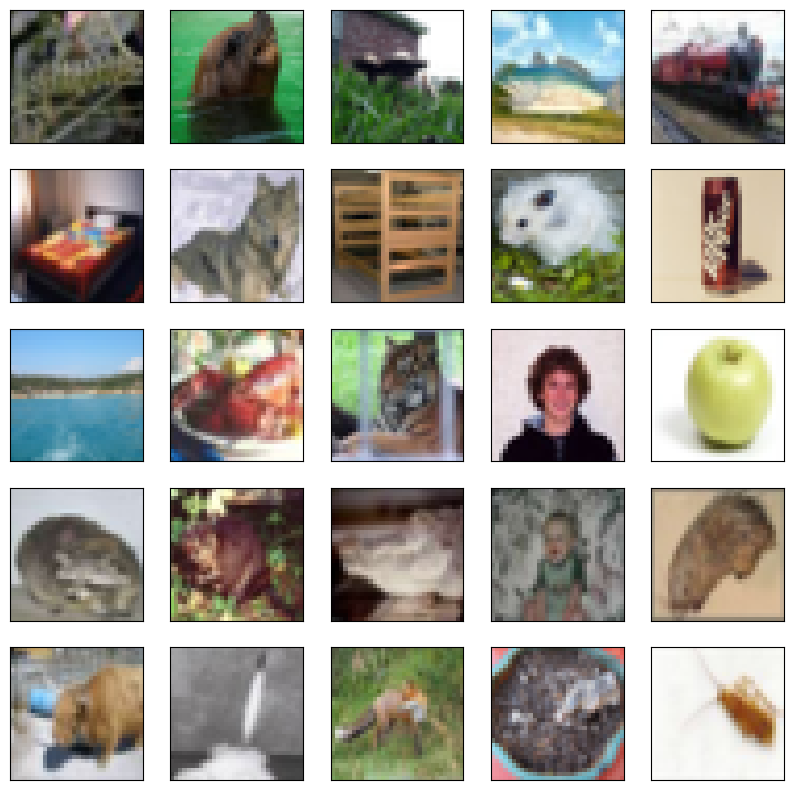

In [19]:
fig, axes = subplots(5, 5, figsize=(10,10))
rng = np.random.default_rng(4)
indices = rng.choice(np.arange(len(cifar_train)), 25, replace=False).reshape((5,5))
for i in range(5):
    for j in range(5):
        idx = indices[i,j]
        axes[i,j].imshow(np.transpose(cifar_train[idx][0], [1,2,0]), interpolation=None)
        axes[i,j].set_xticks([])
        axes[i,j].set_yticks([])

Here the `imshow()` method recognizes from the shape of its argument that it is a 3-dimensional array, with the last dimension indexing the three RGB color channels.

We specify a moderately-sized  CNN for
demonstration purposes,
We use several layers, each consisting of  convolution, ReLU, and max-pooling steps.
We first define a module that defines one of these layers. 
This user-defined  module can now be used in ways just like
`nn.Linear()` or `nn.Dropout()`.

In [20]:
class BuildingBlock(nn.Module):

    def __init__(self, in_channels, out_channels):

        super(BuildingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3), padding='same')
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2,2))

    def forward(self, x):
        return self.pool(self.activation(self.conv(x)))

Notice that we used the `padding = "same"` argument to
`nn.Conv2d()`, which ensures that the output channels have the
same dimension as the input channels. There are 32 channels in the first
hidden layer, in contrast to the three channels in the input layer. We
use a $3\times 3$ convolution filter for each channel in all the layers. Each
convolution is followed by a max-pooling layer over $2\times2$
blocks.

In forming our deep learning model for the `CIFAR100` data, we use several of our `BuildingBlock()`
modules sequentially. This simple example
illustrates some of the power of `torch`. We can
define modules of their own, which can be combined in other
modules. Ultimately, everything is fit by a generic trainer.

In [21]:
class CIFARModel(nn.Module):

    def __init__(self):
        super(CIFARModel, self).__init__()
        sizes = [(3,32),
                 (32,64),
                 (64,128),
                 (128,256)]
        self.conv = nn.Sequential(*[BuildingBlock(in_, out_)
                                    for in_, out_ in sizes])

        self.output = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(2*2*256, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 100))
    def forward(self, x):
        val = self.conv(x)
        val = torch.flatten(val, start_dim=1)
        return self.output(val)

We  build the model and look at the model summary. which tells us about the layers, trainable paramters, etc.

In [22]:
cifar_model = CIFARModel()
summary(cifar_model,
        input_data=X_,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CIFARModel                               [128, 3, 32, 32]          [128, 100]                --
├─Sequential: 1-1                        [128, 3, 32, 32]          [128, 256, 2, 2]          --
│    └─BuildingBlock: 2-1                [128, 3, 32, 32]          [128, 32, 16, 16]         --
│    │    └─Conv2d: 3-1                  [128, 3, 32, 32]          [128, 32, 32, 32]         896
│    │    └─ReLU: 3-2                    [128, 32, 32, 32]         [128, 32, 32, 32]         --
│    │    └─MaxPool2d: 3-3               [128, 32, 32, 32]         [128, 32, 16, 16]         --
│    └─BuildingBlock: 2-2                [128, 32, 16, 16]         [128, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [128, 32, 16, 16]         [128, 64, 16, 16]         18,496
│    │    └─ReLU: 3-5                    [128, 64, 16, 16]         [128, 64, 16, 16]         --
│    │    └─MaxPool2d: 3-6    

The total number of trainable parameters is 964,516.
By studying the size of the parameters, we can see that the channels halve in both
dimensions
after each of these max-pooling operations. After the last of these we
have a layer with  256 channels of dimension $2\times 2$. These are then
flattened to a dense layer of size 1,024 and put side-by-side in one layer. This is followed by a
dropout regularization layer,  then
another dense layer of size 512, and finally, the
output layer.

Up to now, we have been using a default
optimizer in `SimpleModule()`. For this data,
experiments show that a smaller learning rate performs
better than the default 0.01. We use a
custom optimizer here with a learning rate of 0.001.
Besides this, the logging and training
follow a similar pattern to our previous examples. The optimizer
takes an argument `params` that informs
the optimizer which parameters are involved in SGD (stochastic gradient descent).

We saw earlier that entries of a module’s parameters are tensors. In passing
the parameters to the optimizer we are doing more than
simply passing arrays; part of the structure of the graph
is encoded in the tensors themselves.

In [23]:
# reducing the learning rate from 0.01 to 0.001
cifar_optimizer = RMSprop(cifar_model.parameters(), lr=0.001) 
cifar_module = SimpleModule.classification(cifar_model, num_classes=100, optimizer=cifar_optimizer)
cifar_logger = CSVLogger('logs', name='CIFAR100')

In [24]:
# Training the neural network and fitting the data.
cifar_trainer = Trainer(deterministic=True, max_epochs=10, logger=cifar_logger, callbacks=[ErrorTracker()])
cifar_trainer.fit(cifar_module, datamodule=cifar_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | CIFARModel       | 964 K  | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
964 K     Trainable params
0         Non-trainable params
964 K     Total params
3.858     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


This model takes much time for learning as the learning rate is adjusted and it achieves about 42% accuracy on the test
data.

Although this is not terrible for 100-class data (a random
classifier gets 1% accuracy), searching the web we see results around
75%. Typically it takes a lot of architecture carpentry,
fiddling with regularization, and time, to achieve such results.

Let’s take a look at the validation and training accuracy
across epochs.

In [25]:
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                       ['black',
                        'red'],
                       [training_legend,
                        valid_legend]):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='o',
                     color=color,
                     ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

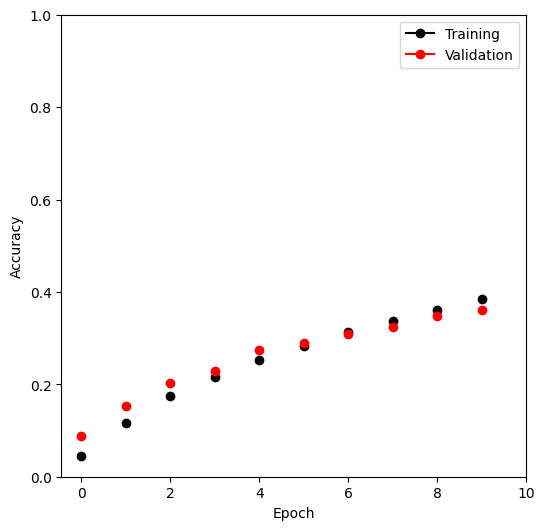

In [26]:
log_path = cifar_logger.experiment.metrics_file_path
cifar_results = pd.read_csv(log_path)
fig, ax = subplots(1, 1, figsize=(6, 6))
summary_plot(cifar_results, ax, col='accuracy', ylabel='Accuracy')
ax.set_xticks(np.linspace(0, 10, 6).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1])

**Observations from the plot :**

Both training and validation accuracy reach above 90%, indicating the model is learning effectively.

The training and validation accuracy curves are very close together throughout the entire training process. This suggests the model is not overfitting to the training data.

While performance is good, slight fluctuations in validation accuracy suggest there might be room for further optimization. Which can be achieved by fine tuning, experimenting with hyperparameters (learning rate, batch size, etc.) to potentially squeeze out a bit more accuracy.


Now, we evaluate our model on our test data.

In [27]:
cifar_trainer.test(cifar_module, datamodule=cifar_dm)

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.3646000027656555
        test_loss            2.479186534881592
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.479186534881592, 'test_accuracy': 0.3646000027656555}]

The test accuracy is approximately 36.46%, which is a relatively low score. This tells that the model is not able to accurately predict the target variable. 

Also, looking at the test loss, indicating model is making number of errors. there may be issues with the quality of the training data, the model architecture, or the training process.

This could be improved by looking for the impure data, missing values. Or could be improved by Hyperparameter tuning: adjusting different hyperparameters, such as learning rate, batch size, or regularization.

### Hardware Acceleration
As deep learning has become ubiquitous in machine learning, hardware
manufacturers have produced special libraries that can
often speed up the gradient-descent steps.

The main changes are to the `Trainer()` call as well as to the metrics
that will be evaluated on the data. These metrics must be told  where
the data will be located at evaluation time. This is
accomplished with a call to the `to()` method of the metrics.

In [28]:
try:
    for name, metric in cifar_module.metrics.items():
        cifar_module.metrics[name] = metric.to('mps')
    cifar_trainer_mps = Trainer(accelerator='mps',
                                deterministic=True,
                                max_epochs=30)
    cifar_trainer_mps.fit(cifar_module,
                          datamodule=cifar_dm)
    cifar_trainer_mps.test(cifar_module,
                          datamodule=cifar_dm)
except:
    pass

This yields approximately two- or three-fold  acceleration for each epoch.
We have protected this code block using `try:` and `except:`
clauses; if it works, we get the speedup, if it fails, nothing happens.

## 10.9.4 Using Pretrained CNN Models
We now show how to use a CNN pretrained on the  `imagenet` database to classify natural
images
We copied six JPEG images from a digital photo album into the
directory `book_images`.

The pretrained network we use is called `resnet50`; specification details can be found on the web.
We will read in the images, and
convert them into the array format expected by the `torch`
software to match the specifications in `resnet50`. 
The conversion involves a resize, a crop and then a predefined standardization for each of the three channels.
We now read in the images and preprocess them.

In [30]:
resize = Resize((232,232), antialias=True)
crop = CenterCrop(224)
normalize = Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
imgfiles = sorted([f for f in glob('book_images/*')])
imgs = torch.stack([torch.div(crop(resize(read_image(f))), 255) for f in imgfiles])
imgs = normalize(imgs)
imgs.size()

torch.Size([5, 3, 224, 224])

The first dimension of the tensor is 5, which indicates that the batch size is 5. This means that the model is processing 5 images at a time.

The second dimension of the tensor is 3, which indicates that the images are in RGB format, with 3 color channels (red, green, and blue).

The third and fourth dimensions of the tensor are 224 and 224, respectively, which indicates that the images are 224x224 pixels in size.

We now set up the trained network with the weights we read in code block~6. The model has 50 layers, with a fair bit of complexity.

In [31]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)
summary(resnet_model, input_data=imgs, col_names=['input_size', 'output_size', 'num_params'])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Samihan Sahasrabudhe/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:12<00:00, 7.91MB/s]


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [5, 3, 224, 224]          [5, 1000]                 --
├─Conv2d: 1-1                            [5, 3, 224, 224]          [5, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [5, 64, 112, 112]         [5, 64, 112, 112]         128
├─ReLU: 1-3                              [5, 64, 112, 112]         [5, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [5, 64, 112, 112]         [5, 64, 56, 56]           --
├─Sequential: 1-5                        [5, 64, 56, 56]           [5, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [5, 64, 56, 56]           [5, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [5, 64, 56, 56]           [5, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [5, 64, 56, 56]           [5, 64, 56, 56]           128
│    │    └─ReLU: 3-3      

Input Shape : The input shape of the model is (5, 3, 224, 224), which indicates that the model is designed to process batches of 5 images, each with 3 color channels (RGB) and a size of 224x224 pixels.

Output Shape : The output shape of the model is (5, 1000), which indicates that the model is designed to output a probability distribution over 1000 classes.

Number of Parameters : The model has a total of approximately 62 million parameters, which is a relatively large number of parameters.

Memory : The estimated total size of the model is approximately 994.40 MB, which indicates that the model requires a significant amount of memory to store and process.

Computation : The forward and backward pass size of the model is approximately 889.16 MB, which indicates that the model requires a significant amount of computational resources to process.

We set the mode to `eval()` to ensure that the model is ready to predict on new data.

In [32]:
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Inspecting the output above, we see that when setting up the
`resnet_model`, the authors defined a `Bottleneck`, much like our
`BuildingBlock` module.

We now feed our six images through the fitted network.

In [33]:
img_preds = resnet_model(imgs)

Let’s look at the predicted probabilities for each of the top 3 choices. First we compute
the probabilities by applying the softmax to the logits in `img_preds`. 

Note that we have had to call the `detach()` method on the tensor `img_preds` in order to convert
it to our a more familiar `ndarray`.

In [34]:
img_probs = np.exp(np.asarray(img_preds.detach()))
img_probs /= img_probs.sum(1)[:,None]

In order to see the class labels, we must download the index file associated with `imagenet`. {This is avalable from the book website and  [s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json](https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json).}

In [38]:
labs = json.load(open('imagenet_class_index.json'))
class_labels = pd.DataFrame([(int(k), v[1]) for k, v in 
                           labs.items()],
                           columns=['idx', 'label'])
class_labels = class_labels.set_index('idx')
class_labels = class_labels.sort_index()

We’ll now construct a data frame for each image file
with the labels with the three highest probabilities as
estimated by the model above.

In [39]:
for i, imgfile in enumerate(imgfiles):
    img_df = class_labels.copy()
    img_df['prob'] = img_probs[i]
    img_df = img_df.sort_values(by='prob', ascending=False)[:3]
    print(f'Image: {imgfile}')
    print(img_df.reset_index().drop(columns=['idx']))

Image: book_images\Cape_Weaver.jpg
      label      prob
0   jacamar  0.297500
1     macaw  0.068107
2  lorikeet  0.051104
Image: book_images\Hawk_Fountain.jpg
            label      prob
0            kite  0.184716
1           robin  0.084018
2  great_grey_owl  0.061267
Image: book_images\Hawk_cropped.jpg
            label      prob
0            kite  0.453834
1  great_grey_owl  0.015914
2             jay  0.012210
Image: book_images\Lhasa_Apso.jpg
             label      prob
0            Lhasa  0.260317
1         Shih-Tzu  0.097195
2  Tibetan_terrier  0.032820
Image: book_images\Sleeping_Cat.jpg
         label      prob
0  Persian_cat  0.163070
1        tabby  0.074143
2    tiger_cat  0.042578


The model is uncertain about the correct label for each image, as the top predicted probability is not extremely high (less than 50% in most cases).

We see that the model
is quite confident about `Flamingo.jpg`, but a little less so for the
other images.

Overall, The model's performance is mediocre. And has a chance of improvement.

The model's performance can be improved by fine-tuning the model, collecting more data, or using techniques such as data augmentation.

We end our experimentation with our usual cleanup.

In [40]:
del(cifar_test,
    cifar_train,
    cifar_dm,
    cifar_module,
    cifar_logger,
    cifar_optimizer,
    cifar_trainer)